# anticipate Ifremer bassin test: 2020 07 01/02

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from copy import deepcopy

import cognac.float as fl

    temperature  salinity  DO_temperature      depth
0        11.891    36.749          11.901  18.300000
1        11.891    36.748          11.910  17.700000
2        11.891    36.748          11.906  16.300000
3        11.892    36.748          11.906  15.600000
4        11.892    36.748          11.906  15.000000
5        11.892    36.748          11.906  13.700000
6        11.893    36.749          11.906  12.300000
7        11.897    36.749          11.909  11.500000
8        11.909    36.753          11.930  10.700000
9        11.979    36.756          11.980   9.799960
10       11.982    36.756          11.986   8.999960
11       11.993    36.757          11.998   7.499960
12       12.009    36.759          12.020   6.199960
13       12.066    36.764          12.100   5.299960
14       12.322    36.786          12.413   4.399960
15       12.754    36.329          13.045   3.499960
16       13.429    35.715          13.663   2.599960
17       14.617    35.176          15.041   1.

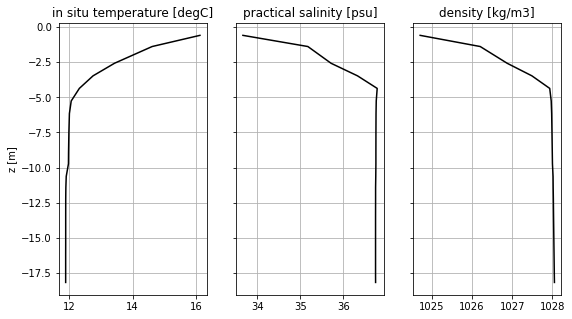

In [2]:
root_dir = '/Users/aponte/Current_projects/cognac/tests/202007_ifremer/bassin2_bags/'
cast = pd.read_csv(root_dir+'profil.csv', 
                   names=['temperature', 'salinity', 'DO_temperature', 'depth',], 
                   skiprows=1, delimiter=';',
                   decimal=","
                  )
print(cast)
#cast['salinity'] = 36 # sans sel
#cast['temperature'] = 14 # sans température

w = fl.waterp(pressure=cast['depth'], 
              temperature=cast['temperature'], 
              salinity=cast['salinity'], 
              lon=6.,lat=40.
             )
print(w)

In [7]:
alpha, beta = w.get_alpha(-5), w.get_beta(-5)
print('alpha={:.2e} and beta={:.2e}'.format(alpha, beta))
V = 1.2e4
dT, dS = 4, 2.5
print('V alpha dT = {:.1f} cm^3'.format(V*alpha*dT))
print('V beta dS  = {:.1f} cm^3'.format(V*beta*dS))

alpha=1.91e-04  et beta=7.48e-04
V alpha dT = 9.2 cm^3
V beta dS  = 22.4 cm^3


In [14]:
import gsw
w.get_s(-10), w.get_temp(-10)

(36.75543570260402, 11.961337552339446)

In [20]:
dCdT = gsw.C_from_SP(36,13,10) - gsw.C_from_SP(36,12,10)
dCdS = gsw.C_from_SP(36,12,10) - gsw.C_from_SP(35,12,10)
print('dCdT = {:.2f}'.format(dCdT))
print('dCdS = {:.2f}'.format(dCdS))
print(4.*dCdT/dCdS)

dCdT = 0.99
dCdS = 1.02
3.875421035404423


In [17]:
gsw.C_from_SP?

Signature: gsw.C_from_SP(SP, t, p)
Docstring:
Calculates conductivity, C, from (SP,t,p) using PSS-78 in the range
2 < SP < 42.  If the input Practical Salinity is less than 2 then a
modified form of the Hill et al. (1986) fomula is used for Practical
Salinity.  The modification of the Hill et al. (1986) expression is to
ensure that it is exactly consistent with PSS-78 at SP = 2.

Parameters
----------
SP : array-like
    Practical Salinity (PSS-78), unitless
t : array-like
    In-situ temperature (ITS-90), degrees C
p : array-like
    Sea pressure (absolute pressure minus 10.1325 dbar), dbar

Returns
-------
C : array-like, mS/cm
    conductivity
File:      ~/.miniconda3/envs/cognac/lib/python3.6/site-packages/gsw/_wrapped_ufuncs.py
Type:      function


--- 
## Instantiate the float object

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-20.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = fl.autonomous_float(model='Ifremer')
f.init_piston()
print(f)

# adjust mass to be at equilibrium at 0m and substract 5g
iz = np.argmin(np.abs(z+0))
f.adjust_m(p[iz],temp[iz],rho_w[iz], offset=-5)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

Piston max volume set from max displacement
Float parameters: 
  L     = 0.83 m      - float length
  r     = 0.07 m      - float radius
  m     = 11.63 kg     - float mass
  V     = 1.27e+04 cm^3   - float volume
  rho_cte = m/V = 9.13e+08 kg.cm^3   - float baseline density
  gamma = 3.78e-06 /dbar  - mechanical compressibility
  gamma x V = 4.82e-02 cm^3/dbar  - normalized compressibility
  alpha = 6.98e-05 /degC  - thermal compressibility
  alpha x V = 8.89e-01 cm^3/degC  - normalized thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 0.97 cm        - piston radius
  d     = 0.00 cm        - present piston displacement
  vol   = 26.88 cm^3      - present volume addition
  d_increment  = 8.57e-02 mm        - smallest variation of translation motion for the p

Piston reset for equilibrium : vol=2.2e+01 cm^3  
z equilibrium = -10.0m


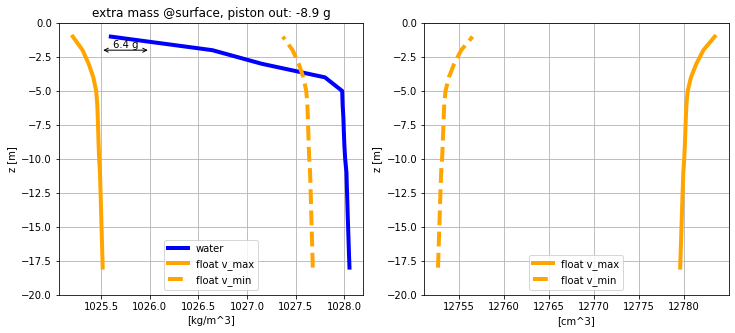

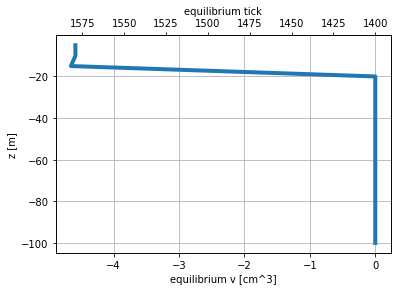

In [4]:
# adjust piston to be at equilibrium -1m
z0 = -1.
iz = np.argmin(np.abs(z-z0))
vstart = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) )

# show densities
fig, ax = plt.subplots(1, 2, figsize=(12,5))
fl.plot_float_density(z, f, w, ax=ax[0])
_ = fl.plot_float_volume(z, f, w, ax=ax[1])
_ = fl.plot_equilibrium_volume(f, w)